# Deep Learning with PyTorch : Build a Generative Adversarial Network 

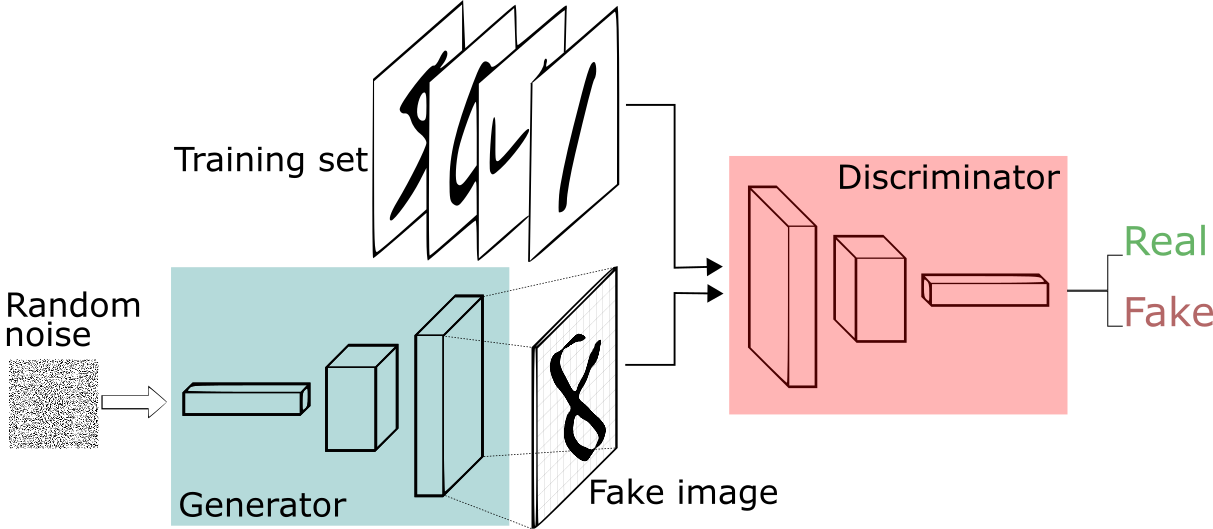

In [29]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [76]:
device = 'cuda'   # image = image.to(device)
batch_size = 128  # trainloader, training loop
noise_dim = 64    # generator model

# Optimizer parameters

lr = 0.0001
beta_1 = 0.45
beta_2 = 0.95

# Training 

epochs = 60

# Load MNIST Dataset 

In [31]:
from torchvision import datasets, transforms as T

In [32]:
train_augs = T.Compose([T.RandomRotation((-20, 20)), T.ToTensor()])   # (h, w, c) -> (c, h, w)

In [33]:
trainset = datasets.MNIST('MNIST/', download = True, train = True, transform = train_augs)

In [34]:
image, label = trainset[1000]
plt.imshow(image.squeeze(), cmap = 'gray')

In [35]:
len(trainset)

60000

# Load Dataset Into Batches 

In [36]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [37]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [38]:
print(len(trainloader))   # Total number of batches in trainloader

469


In [39]:
dataiter = iter(trainloader)
images, _ = dataiter.next()
print(images.shape)

torch.Size([128, 1, 28, 28])


In [40]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

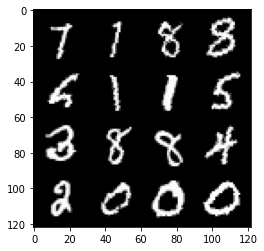

In [41]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network 

In [42]:
#In case if torch summary is not installed 

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [44]:
from torch import nn
from torchsummary import summary

In [45]:
def get_disc_block(in_channels, out_channels, kernal_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernal_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [46]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1, 16, (3, 3), 2)
    self.block_2 = get_disc_block(16, 32, (5, 5), 2)
    self.block_3 = get_disc_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self, images):

    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5


In [47]:
D = Discriminator()
D.to(device)

summary(D, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [48]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                               

In [49]:
def get_gen_block(in_channels, out_channels, kernal_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernal_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernal_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [50]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(self.noise_dim, 256, (3, 3), 2)
    self.block_2 = get_gen_block(256, 128, (4, 4), 1)
    self.block_3 = get_gen_block(128, 64, (3, 3), 2)

    self.block_4 = get_gen_block(64, 1, (4, 4), 2, final_block = True)

  def forward(self, r_noise_vec):

    x = r_noise_vec.view(-1, noise_dim, 1, 1)   # Change input shape for ConvTranspose2D

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [51]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [52]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [77]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [54]:
def real_loss(disc_pred):
  criteria = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criteria(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criteria = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criteria(disc_pred, ground_truth)
  return loss

In [55]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

# Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.5810509484841117 | G_loss : 0.8287708955024605


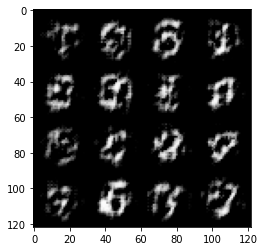

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.6035185423232853 | G_loss : 0.8225179648856873


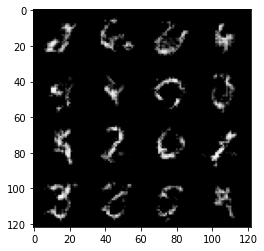

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.5606525913992925 | G_loss : 0.8979772464044566


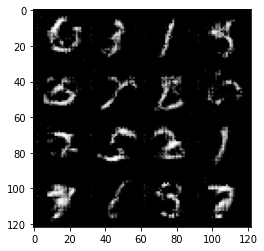

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.5231679429504663 | G_loss : 0.9616826242729545


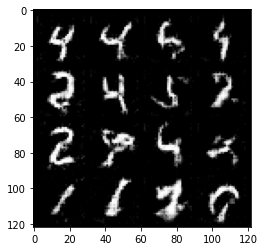

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.5517899446141745 | G_loss : 0.9366784632078874


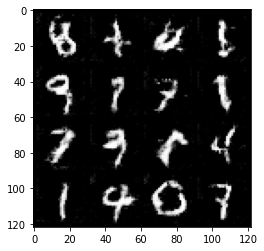

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.5792462752063645 | G_loss : 0.9139045720923938


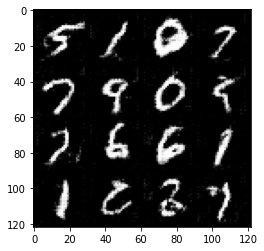

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.6040382366190588 | G_loss : 0.8853436131467188


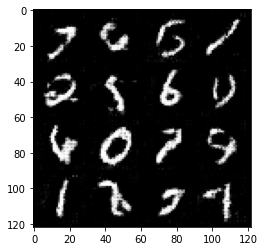

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.6217076693262372 | G_loss : 0.8588728076105179


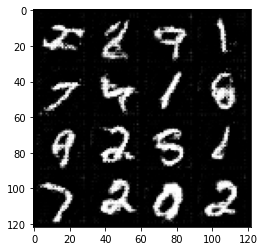

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.6356249906615153 | G_loss : 0.8376999510122515


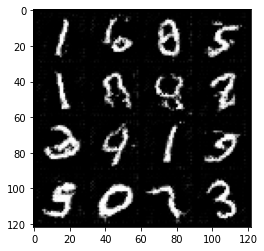

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.6448966582446719 | G_loss : 0.8264815656106863


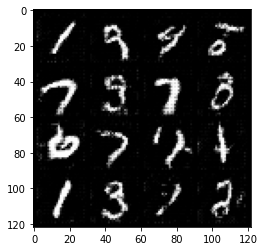

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.6510418425999216 | G_loss : 0.8135218796953718


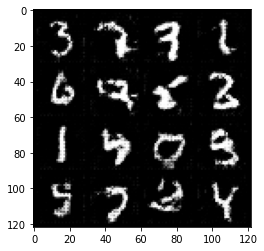

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.6553486729227403 | G_loss : 0.8025119401244466


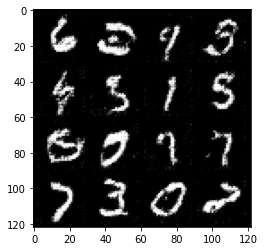

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.660068650489677 | G_loss : 0.7969160781486202


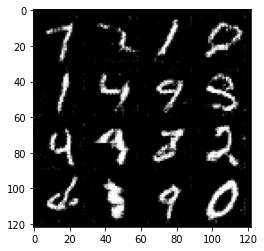

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.6618794232034988 | G_loss : 0.7901387696327177


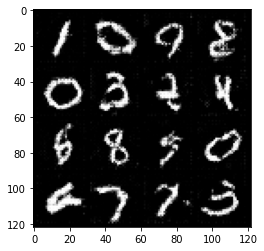

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.6654667188363798 | G_loss : 0.7820614566172618


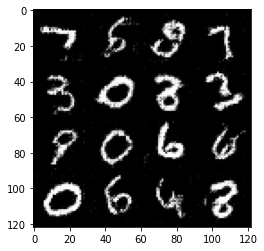

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.665840312616149 | G_loss : 0.7794360188024638


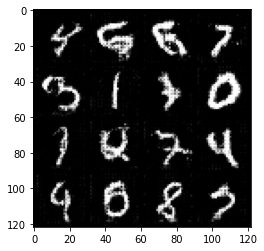

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.6673975068368891 | G_loss : 0.7746231600419798


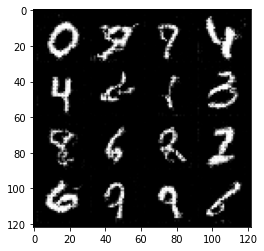

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.6662317520773995 | G_loss : 0.7753648383022625


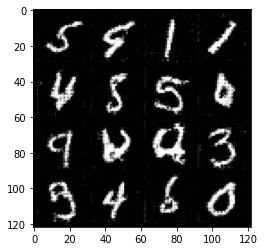

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.6685261455680261 | G_loss : 0.7696721933797986


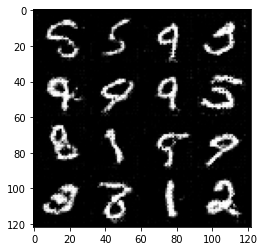

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.6701777541815345 | G_loss : 0.7680510283787367


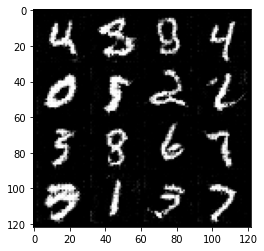

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 21 | D_loss : 0.6701049553051687 | G_loss : 0.7655383129872239


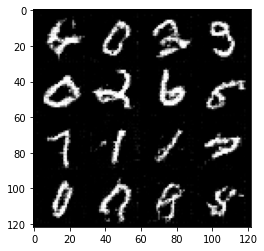

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 22 | D_loss : 0.6692310485250151 | G_loss : 0.769344086586031


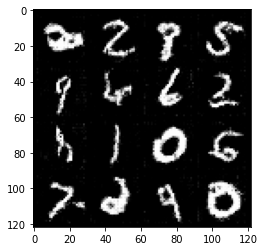

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 23 | D_loss : 0.6662441122252295 | G_loss : 0.7717712461821306


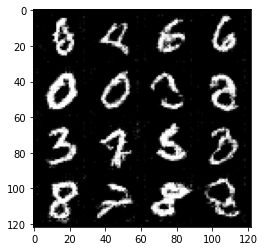

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 24 | D_loss : 0.6582571545135237 | G_loss : 0.782972261341396


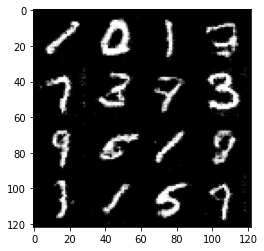

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 25 | D_loss : 0.6414043674590999 | G_loss : 0.8120493689325573


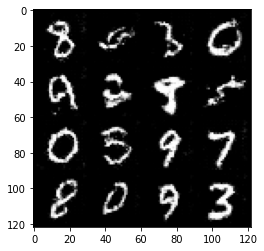

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 26 | D_loss : 0.6166457682530254 | G_loss : 0.8554992680864801


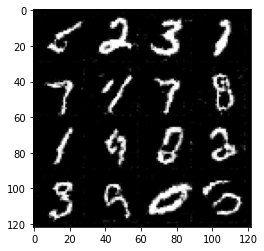

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 27 | D_loss : 0.6226943376730246 | G_loss : 0.8583312398080887


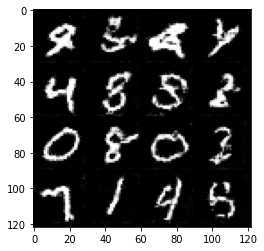

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 28 | D_loss : 0.6271135649447248 | G_loss : 0.8530100439148925


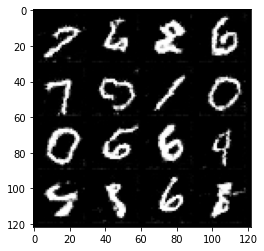

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 29 | D_loss : 0.628552467965368 | G_loss : 0.8579123997484951


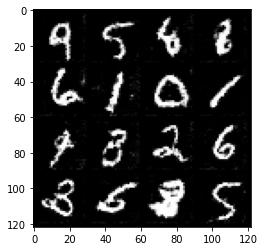

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 30 | D_loss : 0.6304553363368963 | G_loss : 0.8533856876369225


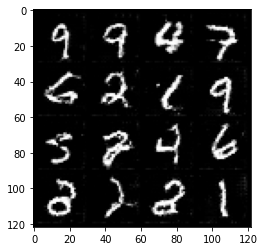

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 31 | D_loss : 0.6319279514396114 | G_loss : 0.854125336670418


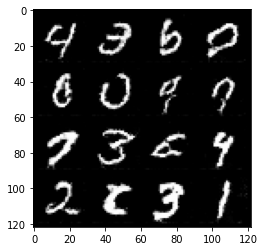

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 32 | D_loss : 0.6339944416780208 | G_loss : 0.8530779202609683


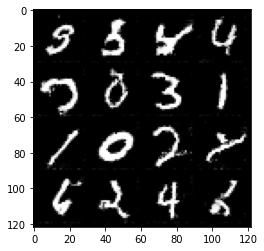

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 33 | D_loss : 0.6361124622288035 | G_loss : 0.8482485182249724


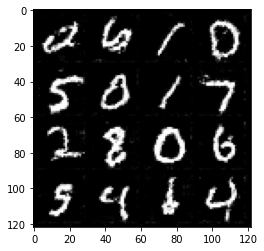

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 34 | D_loss : 0.6395308027135284 | G_loss : 0.8459658737121615


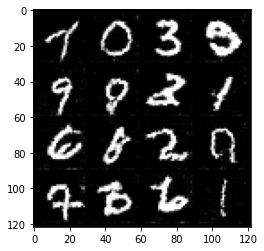

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 35 | D_loss : 0.6420326332039417 | G_loss : 0.8378994105212978


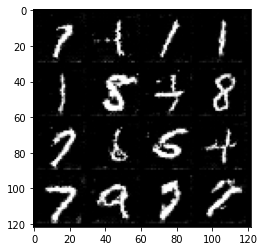

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 36 | D_loss : 0.6464243134710072 | G_loss : 0.8357251045037942


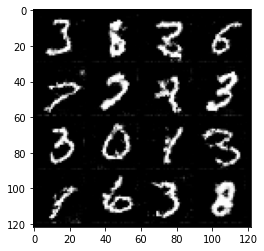

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 37 | D_loss : 0.6465702572865273 | G_loss : 0.8265942068242315


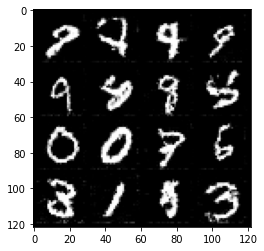

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 38 | D_loss : 0.64864555249082 | G_loss : 0.827705196988608


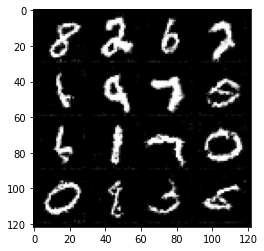

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 39 | D_loss : 0.6502227180802238 | G_loss : 0.8233737039413533


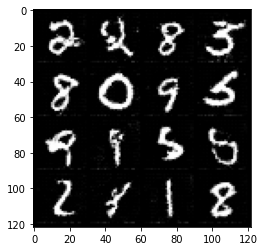

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 40 | D_loss : 0.6548103747337357 | G_loss : 0.8123885691801368


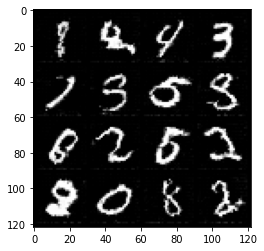

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 41 | D_loss : 0.656675794739713 | G_loss : 0.8127027273432278


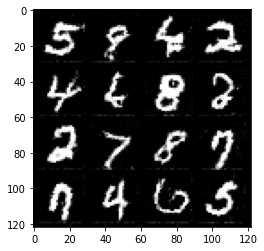

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 42 | D_loss : 0.6610397078843513 | G_loss : 0.8052213878265576


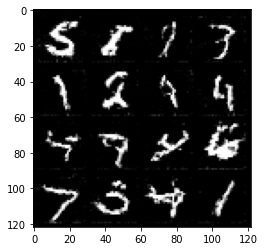

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 43 | D_loss : 0.6625859725958249 | G_loss : 0.7997250431127894


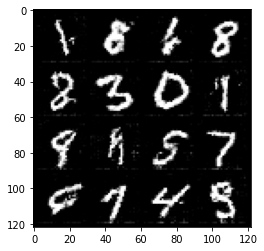

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 44 | D_loss : 0.6618047506570308 | G_loss : 0.7978566037312246


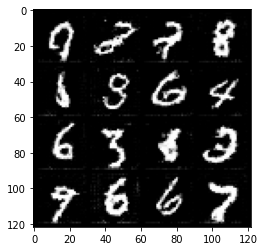

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 45 | D_loss : 0.6638941112866026 | G_loss : 0.7947954443980382


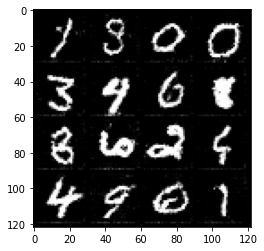

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 46 | D_loss : 0.6638766968174021 | G_loss : 0.793510460396057


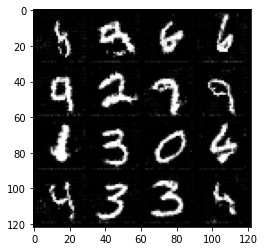

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 47 | D_loss : 0.6675571862822657 | G_loss : 0.7904319619573256


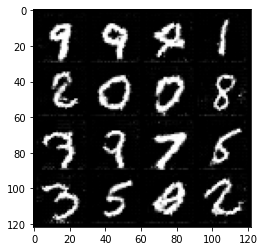

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 48 | D_loss : 0.6659411981161724 | G_loss : 0.7862990554461855


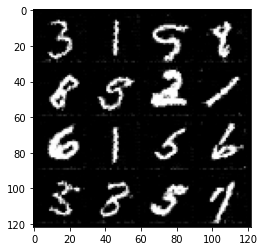

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 49 | D_loss : 0.6666716497335861 | G_loss : 0.7856290555203648


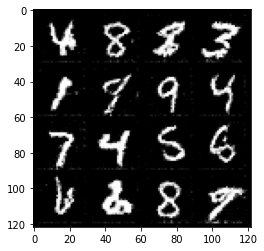

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 50 | D_loss : 0.6680226397158494 | G_loss : 0.7867664411378059


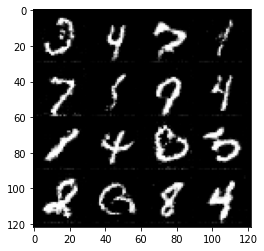

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 51 | D_loss : 0.6674038729687998 | G_loss : 0.7801879542722885


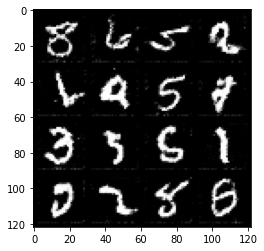

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 52 | D_loss : 0.6701343641606475 | G_loss : 0.779852244518459


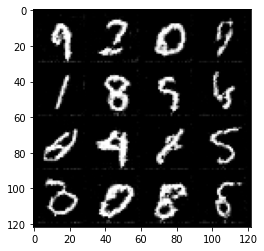

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 53 | D_loss : 0.6674389995491581 | G_loss : 0.7818344535349783


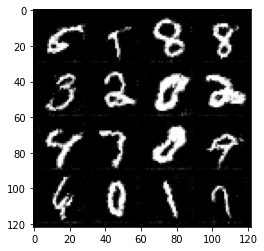

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 54 | D_loss : 0.667365369512074 | G_loss : 0.7809093764850071


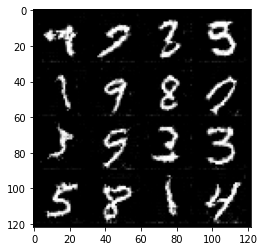

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 55 | D_loss : 0.6680931917894115 | G_loss : 0.7775366322826475


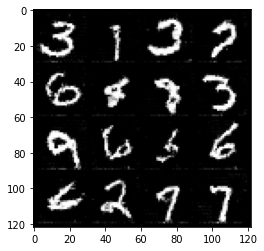

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 56 | D_loss : 0.6671213003109767 | G_loss : 0.7782322437778465


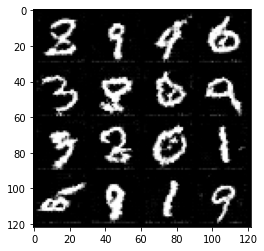

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 57 | D_loss : 0.6686674620805264 | G_loss : 0.7820289460326563


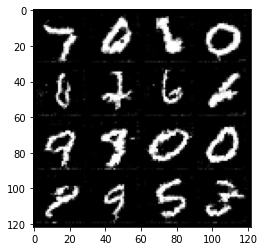

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 58 | D_loss : 0.6685861842210359 | G_loss : 0.7756889757317013


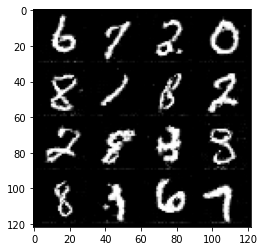

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 59 | D_loss : 0.6693513120161191 | G_loss : 0.7789106454168048


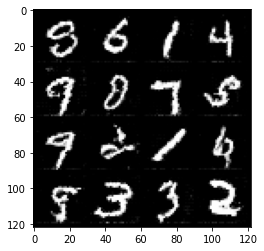

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 60 | D_loss : 0.6700231054190126 | G_loss : 0.7753726710388655


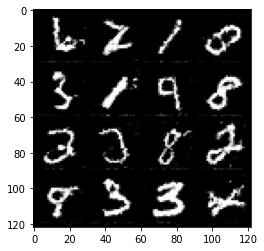

In [78]:
for i in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    # Find loss and update weight for D

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss) / 2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # Find loss and update weight for G

    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch : {} | D_loss : {} | G_loss : {}".format(i + 1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)

In [86]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image, num_images = 1)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya